In [1]:
!pip install pretrainedmodels

    100% |████████████████████████████████| 61kB 5.1MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pretrainedmodels

In [2]:
import os

In [3]:
os.listdir("./data/train/train")

['cmd', 'healthy', 'cbsd', 'cbb', 'cgm']

In [4]:
os.listdir("./data/train/train/cgm")[:10]

['train-cgm-100.jpg',
 'train-cgm-155.jpg',
 'train-cgm-193.jpg',
 'train-cgm-391.jpg',
 'train-cgm-200.jpg',
 'train-cgm-484.jpg',
 'train-cgm-12.jpg',
 'train-cgm-599.jpg',
 'train-cgm-63.jpg',
 'train-cgm-477.jpg']

In [5]:
os.listdir("./data/test/test/0")[:10]

['test-img-1551.jpg',
 'test-img-311.jpg',
 'test-img-600.jpg',
 'test-img-1092.jpg',
 'test-img-156.jpg',
 'test-img-3555.jpg',
 'test-img-2170.jpg',
 'test-img-3393.jpg',
 'test-img-1523.jpg',
 'test-img-2519.jpg']

In [6]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

from math import floor

In [7]:
train_path = "./data/train/train"
test_path = "./data/test/test/0"

In [8]:
def get_labels(file_path): 
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_levels = len(split_dir_name)
    label  = split_dir_name[dir_levels - 1]
    return(label)

In [9]:
get_labels("./data/train/train/cgm/train-cgm-528.jpg")

'cgm'

In [10]:
from glob import glob
imagePatches = glob("./data/train/train/*/*.*", recursive=True)
imagePatches[0:10]

['./data/train/train/cmd/train-cmd-634.jpg',
 './data/train/train/cmd/train-cmd-1039.jpg',
 './data/train/train/cmd/train-cmd-2023.jpg',
 './data/train/train/cmd/train-cmd-73.jpg',
 './data/train/train/cmd/train-cmd-1933.jpg',
 './data/train/train/cmd/train-cmd-449.jpg',
 './data/train/train/cmd/train-cmd-2276.jpg',
 './data/train/train/cmd/train-cmd-1450.jpg',
 './data/train/train/cmd/train-cmd-674.jpg',
 './data/train/train/cmd/train-cmd-1204.jpg']

In [11]:
path=""
tfms = get_transforms() 

In [12]:
data = ImageDataBunch.from_name_func(path, imagePatches, label_func=get_labels,  size=500, 
                                     bs=20,num_workers=2,test = test_path,ds_tfms=tfms
                                  ).normalize(imagenet_stats)

In [13]:
type(data)

fastai.vision.data.ImageDataBunch

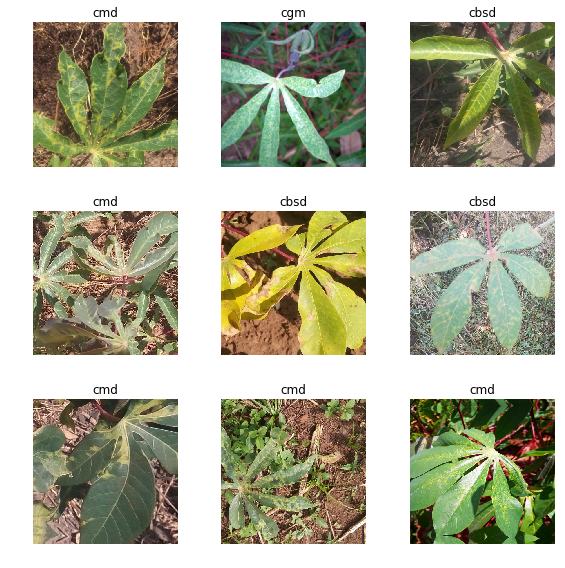

In [14]:
data.show_batch(rows=3, figsize=(8,8))

In [15]:
def se_resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return model

In [16]:
learner = cnn_learner(data, se_resnext50_32x4d, pretrained=True,
                   cut=-2, split_on=lambda m: (m[0][3], m[1]),metrics = [accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


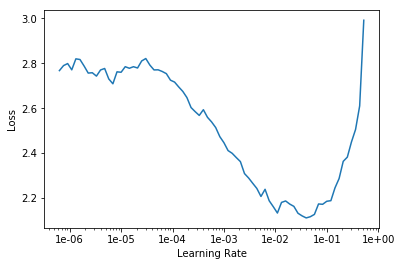

In [17]:
learner.lr_find()
learner.recorder.plot()

In [18]:
lr=1e-1
learner.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.774004,3.955002,0.580018,02:02


In [19]:
learner.save('model-1')

In [ ]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


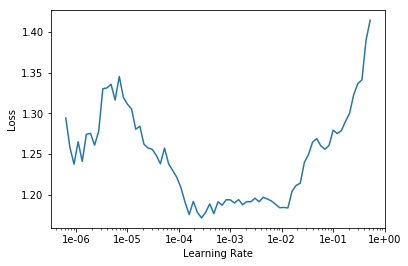

In [20]:
learner.lr_find()
learner.recorder.plot()

In [21]:
learner.load('model-1')
learner.fit_one_cycle(60, slice(3e-3,3e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.131861,15.518807,0.603890,02:01
1,1.112412,35.900024,0.612732,02:00
2,1.095325,45.764767,0.626879,02:00
3,1.053606,67.909935,0.611848,02:00
4,0.977969,45.863213,0.625995,02:00
5,0.979059,38.525833,0.647215,02:01
6,0.913121,7.365958,0.639257,02:01
7,0.892997,61.127285,0.655172,02:01
8,0.904092,25.699520,0.687003,02:00
9,0.929068,27.035366,0.645446,02:00


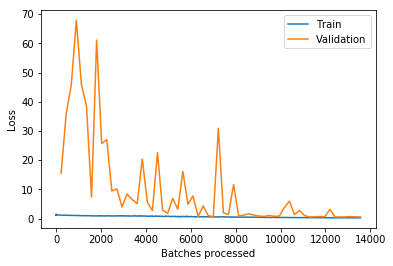

In [22]:
learner.recorder.plot_losses()

In [23]:
learner.validate()

[0.5625481, tensor(0.8426)]

In [24]:
interp = ClassificationInterpretation.from_learner(learner)

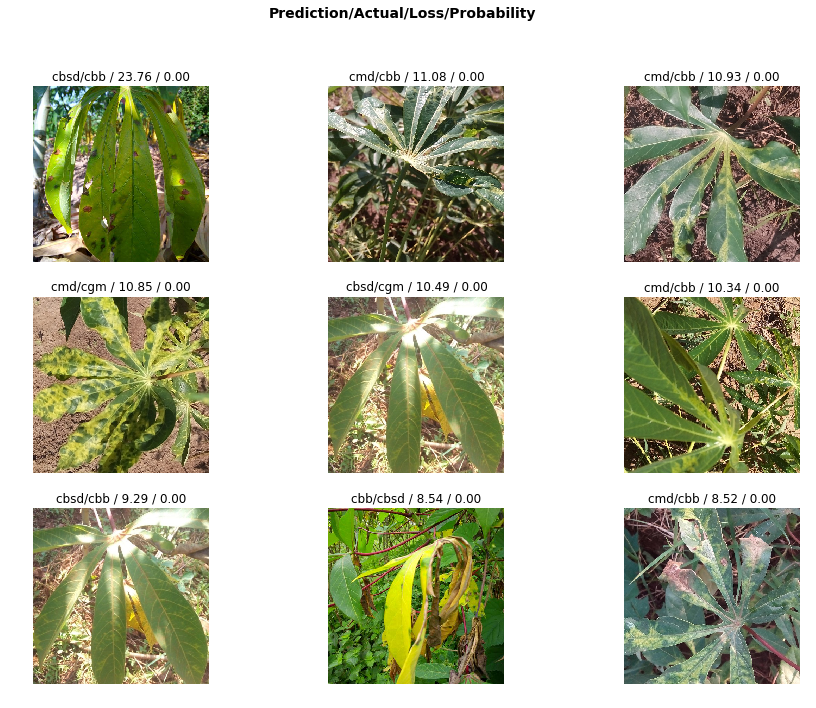

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

In [26]:
interp.most_confused(min_val=2)

[('cbb', 'cbsd', 29),
 ('cbsd', 'cbb', 23),
 ('cgm', 'cmd', 23),
 ('cbb', 'cmd', 17),
 ('cmd', 'cgm', 16),
 ('cmd', 'cbsd', 14),
 ('cbb', 'cgm', 10),
 ('cgm', 'cbsd', 10),
 ('cbsd', 'cmd', 9),
 ('healthy', 'cbb', 6),
 ('cmd', 'cbb', 4),
 ('healthy', 'cbsd', 4),
 ('healthy', 'cmd', 4),
 ('cbsd', 'cgm', 3),
 ('cgm', 'cbb', 3),
 ('healthy', 'cgm', 2)]

In [27]:
preds,y = learner.TTA(ds_type=DatasetType.Test)

In [28]:
len(preds)

3774

In [29]:
len(os.listdir(test_path))

3774

In [30]:
SAMPLE_SUB = './data/sample_submission_file.csv'
sample_df = pd.read_csv(SAMPLE_SUB)

In [31]:
sample_df.head()

,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


In [32]:
predictions = preds.numpy()

In [33]:
class_preds = np.argmax(predictions, axis=1)

In [34]:
for c, i in learner.data.train_ds.y.c2i.items():
    print(c,i)

cbb 0
cbsd 1
cgm 2
cmd 3
healthy 4


In [35]:
categories = ['cbb','cbsd','cgm','cmd','healthy']

def map_to_categories(predictions):
    return(categories[predictions])

categories_preds = list(map(map_to_categories,class_preds))

In [36]:
filenames = list(map(os.path.basename,os.listdir(test_path)))

In [37]:
df_sub = pd.DataFrame({'Category':categories_preds,'Id':filenames})

In [38]:
df_sub.head()

,Category,Id
0,cmd,test-img-1551.jpg
1,cmd,test-img-311.jpg
2,cbsd,test-img-600.jpg
3,cmd,test-img-1092.jpg
4,healthy,test-img-156.jpg


In [39]:
# Export to csv
df_sub.to_csv('submission_categories_2.csv', header=True, index=False)